##### 1. Critical Windows fix and starts the Spark session.

In [15]:
import os
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType

# --- ⚠️ Critical Windows Fix (HADOOP_HOME) ---
# Assuming you set C:\hadoop during the previous fix
if os.name == 'nt':
    HADOOP_HOME_DIR = "C:\\hadoop"
    os.environ["HADOOP_HOME"] = HADOOP_HOME_DIR
    os.environ["PATH"] = os.environ.get("PATH", "") + ";" + HADOOP_HOME_DIR + "\\bin"
# ---------------------------------------------

# --- Configuration ---
FULL_RAW_DATA_PATH = "data/processed/full_raw_data.parquet"
CLEAN_DATA_PATH = "data/processed/clean_trips_data_notebook" # New output path to avoid conflict
PARTITION_COLUMN = "pickup_date"  # Use the confirmed correct column
TRIP_DURATION_COL = "trip_duration_seconds"
ROUTE_ID_COL = "ratecodeid"

# Initialize Spark Session
spark = (
    SparkSession.builder
    .appName("TransitETLNotebook")
    .getOrCreate()
)
print("Spark Session Initialized.")

Spark Session Initialized.


##### 2. Data Loading and Schema Check

In [16]:
# Read raw data
raw_df = spark.read.parquet(FULL_RAW_DATA_PATH)
print(f"Initial row count: {raw_df.count()}")

# Display the schema (Essential for checking column names)
raw_df.printSchema()

# Display a sample of the data
raw_df.limit(5).toPandas()

Initial row count: 2964624
root
 |-- vendorid: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5


##### 3. Data Cleaning and Transformation (ETL)

In [17]:
print("Starting Data Cleaning and Transformation...")

# 1. Select and Clean Columns
clean_df = raw_df.select(
    F.col("tpep_pickup_datetime"),
    F.col("tpep_dropoff_datetime"),
    F.col("passenger_count").cast(IntegerType()),
    F.col("trip_distance").cast(DoubleType()),
    F.col("fare_amount").cast(DoubleType()),
    F.col("tip_amount").cast(DoubleType()),
    F.col("tolls_amount").cast(DoubleType()),
    F.col("total_amount").cast(DoubleType()),
    F.col("payment_type").cast(IntegerType()),
    F.col("RateCodeID").alias(ROUTE_ID_COL).cast(IntegerType()) # Aliasing for analysis script
)

# 2. Add Calculated Fields
clean_df = clean_df.withColumn(
    TRIP_DURATION_COL,
    F.unix_timestamp(F.col("tpep_dropoff_datetime")) - F.unix_timestamp(F.col("tpep_pickup_datetime"))
).withColumn(
    "pickup_date",
    F.date_format(F.col("tpep_pickup_datetime"), "yyyy-MM-dd") # This is your partition column!
)

# 3. Filtering (Basic Quality Check)
clean_df = clean_df.filter(
    (F.col(TRIP_DURATION_COL) > 60) &  # Trips longer than 60 seconds
    (F.col("trip_distance") > 0.1) &   # Trips longer than 0.1 miles
    (F.col("fare_amount") > 2.5)      # Fare greater than minimum
)

print(f"Transformed and cleaned row count: {clean_df.count()}")

Starting Data Cleaning and Transformation...
Transformed and cleaned row count: 2856479


##### 4. Writing Partitioned Data

In [18]:
print(f"Writing partitioned data to {CLEAN_DATA_PATH}...")

clean_df.write.mode("overwrite").partitionBy(PARTITION_COLUMN).parquet(CLEAN_DATA_PATH)

print("ETL complete. Clean data written to disk.")

Writing partitioned data to data/processed/clean_trips_data_notebook...
ETL complete. Clean data written to disk.


##### 5. Analysis - Total Trips by Date

In [19]:
print("\n--- Analysis 1: Total Trip Count by Partition Column ---")

# Ensure the DataFrame uses the saved data
analyzed_df = spark.read.parquet(CLEAN_DATA_PATH)
analyzed_df.createOrReplaceTempView("clean_trips")

query_1 = f"""
    SELECT
        {PARTITION_COLUMN} AS date,
        COUNT(*) AS total_trips
    FROM clean_trips
    GROUP BY 1
    ORDER BY 1
"""
trips_by_date = spark.sql(query_1)

# Display results directly in the notebook
trips_by_date.limit(10).toPandas()


--- Analysis 1: Total Trip Count by Partition Column ---


,date,total_trips
0,2002-12-31,1
1,2009-01-01,3
2,2023-12-31,10
3,2024-01-01,74955
4,2024-01-02,72639
5,2024-01-03,79586
6,2024-01-04,99780
7,2024-01-05,99739
8,2024-01-06,93289
9,2024-01-07,64843


##### 6. Analysis - Top Routes & Average Duration

In [20]:
print("\n--- Analysis 2: Average Duration for Top 5 Routes ---")

# 1. Calculate average trip duration for these routes
avg_duration_query = analyzed_df.groupBy(ROUTE_ID_COL).agg(
    F.count("*").alias("Total_Trips"),
    F.mean(TRIP_DURATION_COL).alias("Average_Trip_Duration_Seconds")
).orderBy(F.col("Total_Trips").desc())

# Display top 5 results
avg_duration_query.limit(5).toPandas()


--- Analysis 2: Average Duration for Top 5 Routes ---


,ratecodeid,Total_Trips,Average_Trip_Duration_Seconds
0,1.0,2603486,854.206140
1,NaN,113617,969.173302
2,2.0,92725,2764.496220
3,99.0,27031,2856.594910
4,3.0,7063,2265.317429


##### 7. Setup and Data Preparation

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set a standard plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6) # Default figure size

# Convert Spark Results to Pandas for plotting
trips_by_date_pd = trips_by_date.toPandas()
avg_duration_pd = avg_duration_query.toPandas()

print("Pandas DataFrames for visualization created.")

Pandas DataFrames for visualization created.


##### 8. Visualization 1 - Trips Over Time (Time Series)

Generating Plot 1: Daily Trip Volume


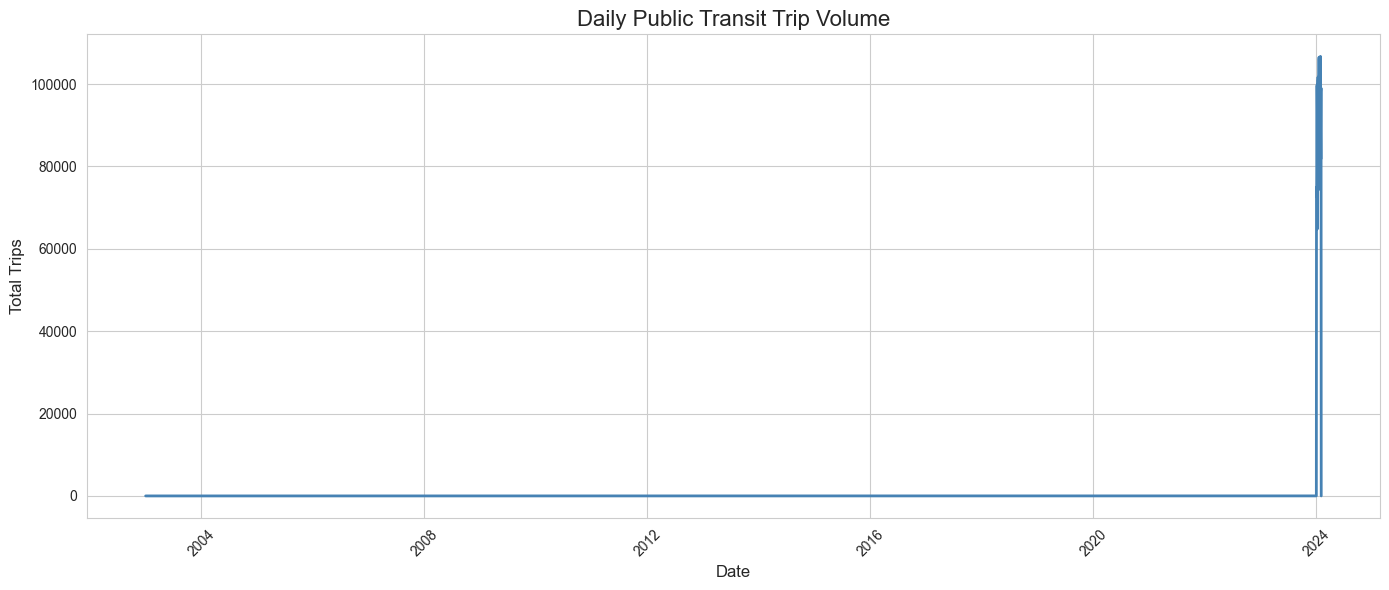

In [22]:
print("Generating Plot 1: Daily Trip Volume")

# Ensure the 'date' column is a proper datetime object for plotting
trips_by_date_pd['date'] = pd.to_datetime(trips_by_date_pd['date'])

# Create a line plot to show trends
plt.figure(figsize=(14, 6))
sns.lineplot(
    x='date', 
    y='total_trips', 
    data=trips_by_date_pd, 
    color='steelblue', 
    linewidth=2
)
plt.title('Daily Public Transit Trip Volume', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Trips', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 9. Visualization 2 - Top Routes Analysis (Bar Chart)

Generating Plot 2: Top 5 Routes - Total Trips vs. Avg Duration


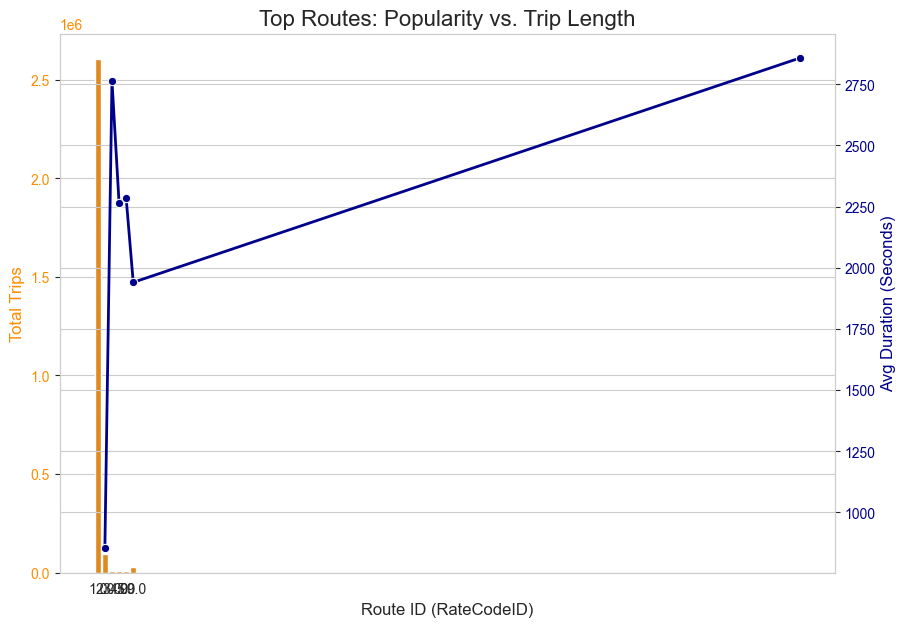

In [23]:
print("Generating Plot 2: Top 5 Routes - Total Trips vs. Avg Duration")

# Sort the data by Total_Trips in descending order for the visualization
plot_data = avg_duration_pd.sort_values(by="Total_Trips", ascending=False)

# Create a figure with two subplots (axes)
fig, ax1 = plt.subplots(figsize=(10, 7))

# --- Plot 1: Total Trips (Bar Chart) ---
sns.barplot(
    x=ROUTE_ID_COL, 
    y="Total_Trips", 
    data=plot_data, 
    ax=ax1, 
    color='darkorange'
)
ax1.set_xlabel('Route ID (RateCodeID)', fontsize=12)
ax1.set_ylabel('Total Trips', color='darkorange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkorange')


# --- Plot 2: Average Duration (Line Plot on Secondary Axis) ---
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
sns.lineplot(
    x=ROUTE_ID_COL, 
    y="Average_Trip_Duration_Seconds", 
    data=plot_data, 
    ax=ax2, 
    color='darkblue', 
    marker='o', 
    linewidth=2
)
ax2.set_ylabel('Avg Duration (Seconds)', color='darkblue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkblue')

plt.title('Top Routes: Popularity vs. Trip Length', fontsize=16)
plt.show()

##### 10. Visualization 3 - Distribution of Trip Distances (Histogram)

Generating Plot 3: Distribution of Trip Distances


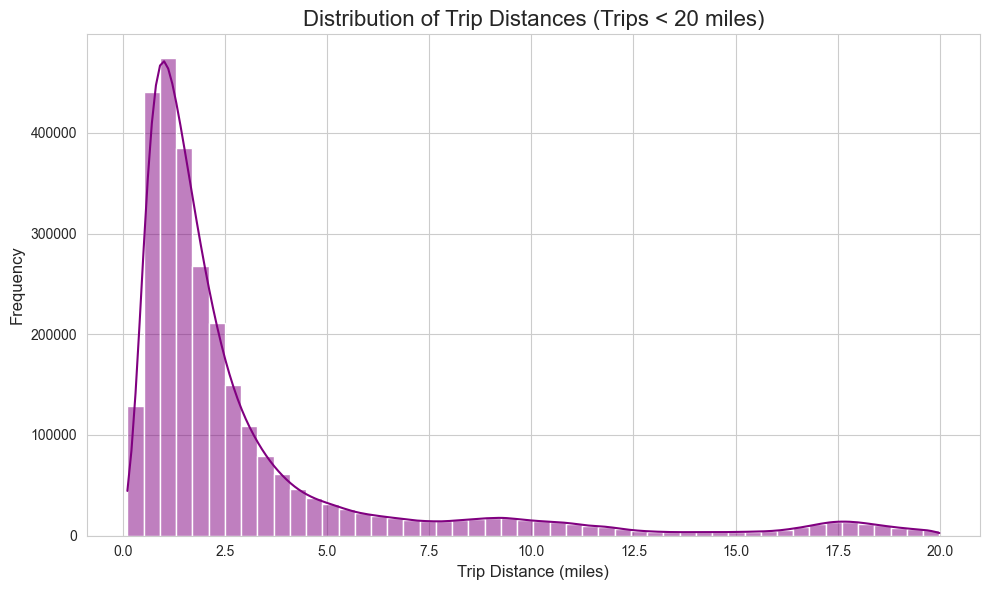

In [24]:
print("Generating Plot 3: Distribution of Trip Distances")

# Load the full clean DataFrame for this (if not already loaded in analyzed_df)
# For better visualization, we'll filter out very long distances that skew the histogram
distance_data = analyzed_df.select("trip_distance").filter(F.col("trip_distance") < 20).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(distance_data['trip_distance'], bins=50, kde=True, color='purple')
plt.title('Distribution of Trip Distances (Trips < 20 miles)', fontsize=16)
plt.xlabel('Trip Distance (miles)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

##### 11. Visualization 4 - Passenger Count Distribution (Bar Plot)

Generating Plot 4: Passenger Count Distribution


C:\Users\Test\AppData\Local\Temp\ipykernel_24656\2110205171.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




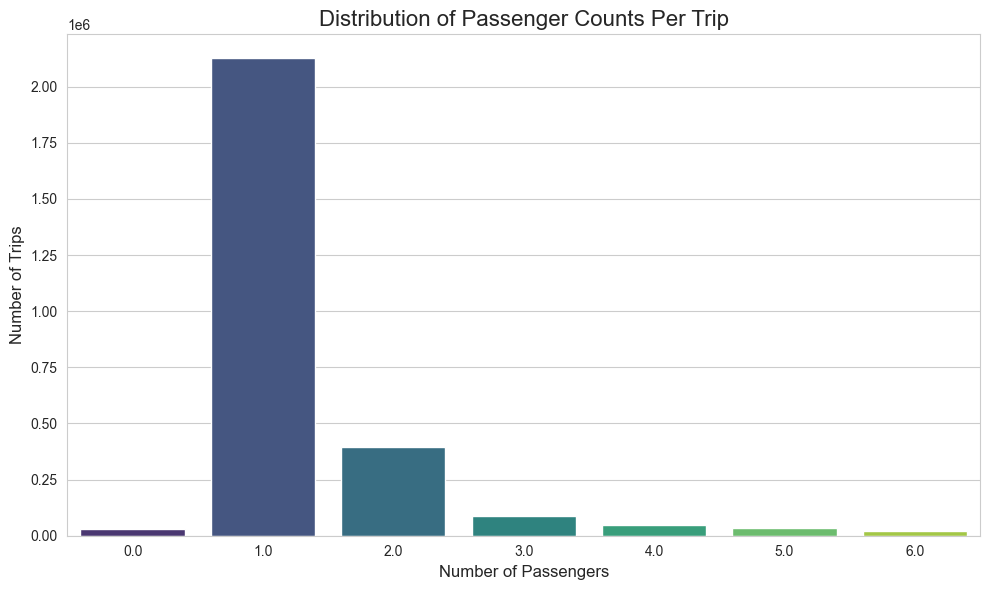

In [25]:
print("Generating Plot 4: Passenger Count Distribution")

# Calculate passenger counts and convert to Pandas
passenger_counts_pd = analyzed_df.groupBy("passenger_count").count().orderBy("passenger_count").toPandas()

# Filter out very high (and likely incorrect) passenger counts for better visualization
passenger_counts_pd = passenger_counts_pd[passenger_counts_pd['passenger_count'] <= 6] # Assuming max reasonable is 6

plt.figure(figsize=(10, 6))
sns.barplot(
    x='passenger_count', 
    y='count', 
    data=passenger_counts_pd, 
    palette='viridis'
)
plt.title('Distribution of Passenger Counts Per Trip', fontsize=16)
plt.xlabel('Number of Passengers', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### 12. Setup and Interactive Plot 1 - Daily Trip Volume

In [26]:
import plotly.express as px

print("Generating Interactive Plot 1: Daily Trip Volume")

# Ensure the Pandas DataFrame from Cell 5 is available (trips_by_date_pd)

fig1 = px.line(
    trips_by_date_pd, 
    x='date', 
    y='total_trips', 
    title='Interactive Daily Public Transit Trip Volume',
    labels={'total_trips': 'Total Trips', 'date': 'Date'}
)

# Customize the layout for better presentation
fig1.update_traces(line_color='darkblue', line_width=2)
fig1.update_layout(hovermode="x unified") # Shows all data points for a given date on hover

fig1.show()

Generating Interactive Plot 1: Daily Trip Volume


##### 13. Interactive Plot 2 - Top Routes Analysis (Combined Bar/Line)

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Generating Interactive Plot 2: Top Routes - Popularity vs. Avg Duration")

# Ensure the Pandas DataFrame from Cell 6 is available (avg_duration_pd)

# Sort the data by Total_Trips for a meaningful visual order
plot_data_sorted = avg_duration_pd.sort_values(by="Total_Trips", ascending=False)

# Create a figure with secondary y-axis
fig2 = make_subplots(specs=[[{"secondary_y": True}]])

# 1. Add Bar Trace for Total Trips (Primary Y-axis)
fig2.add_trace(
    go.Bar(
        x=plot_data_sorted[ROUTE_ID_COL].astype(str), 
        y=plot_data_sorted["Total_Trips"], 
        name="Total Trips", 
        marker_color='darkorange'
    ),
    secondary_y=False,
)

# 2. Add Line Trace for Average Duration (Secondary Y-axis)
fig2.add_trace(
    go.Scatter(
        x=plot_data_sorted[ROUTE_ID_COL].astype(str), 
        y=plot_data_sorted["Average_Trip_Duration_Seconds"], 
        name="Average Duration (Sec)", 
        mode='lines+markers', 
        line_color='darkblue'
    ),
    secondary_y=True,
)

# Add title and axes labels
fig2.update_layout(
    title_text="Top Routes: Popularity vs. Trip Length (Interactive)",
    hovermode="x unified"
)
fig2.update_xaxes(title_text=f"Route ID ({ROUTE_ID_COL})")
fig2.update_yaxes(title_text="Total Trips", secondary_y=False, title_font=dict(color='darkorange'))
fig2.update_yaxes(title_text="Avg Duration (Seconds)", secondary_y=True, title_font=dict(color='darkblue'))

fig2.show()

Generating Interactive Plot 2: Top Routes - Popularity vs. Avg Duration
